We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).
Your project is to:
* Predict conversion rate
* Come up with recommendations for the product team and the marketing team to improve conversion rate

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, classification_report,confusion_matrix


import warnings
warnings.simplefilter('ignore')

# 1. load data

In [47]:
df = pd.read_csv('conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [48]:
df.shape

(316200, 6)

In [49]:
print(df['converted'].value_counts())
print('')
print('Conversion Rate: ', round(df['converted'].value_counts()[1]/len(df),2))

0    306000
1     10200
Name: converted, dtype: int64

Conversion Rate:  0.03


In [50]:
# Check missing values
# this dataset doesn't have missing value
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

# 2. Data Processing

In [51]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [52]:
#age 123 is a outlier
df.loc[df['age']>90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [53]:
# remove outlier
df = df.loc[df['age']<90]
df.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


# 3. Exploratory data analysis

In [54]:
country_dist = pd.DataFrame(df.loc[:,'country'].value_counts())
country_dist

,country
US,178092
China,76602
UK,48449
Germany,13055


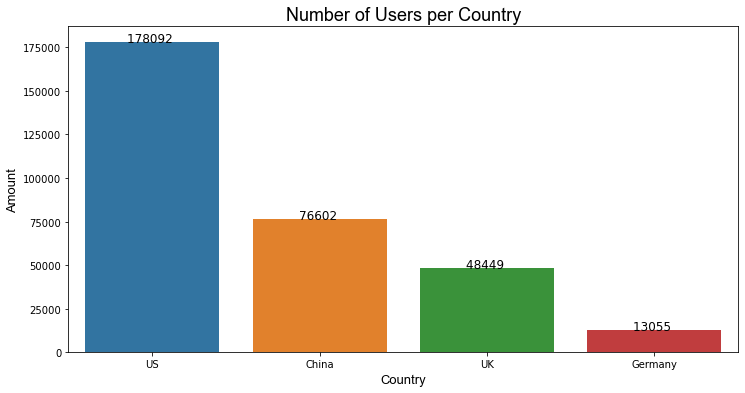

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=country_dist.index,y='country',data=country_dist)
plt.title('Number of Users per Country',fontdict={'fontname': 'Arial', 'fontsize': 18})
plt.xlabel('Country', fontdict={'fontname': 'Arial', 'fontsize': 13})
plt.ylabel('Amount', fontdict={'fontname': 'Arial', 'fontsize': 13})

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f} '.format(( p.get_height()))
            ax.text(_x, _y, value, ha="center", size = 12)            

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)


plt.show()

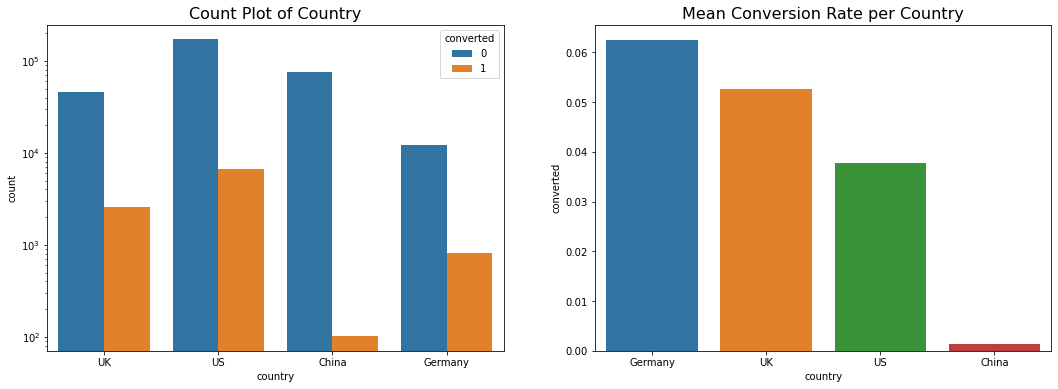

In [56]:
## visualization of different countries

group_df = df.loc[:,['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))

sns.countplot(x='country', hue='converted',data=df,ax=ax[0])
ax[0].set_title('Count Plot of Country',fontsize=16)
ax[0].set_yscale('log')

sns.barplot(x='country',y='converted',data=group_df,order=group_df.sort_values('converted', ascending=False).country, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)

plt.show()

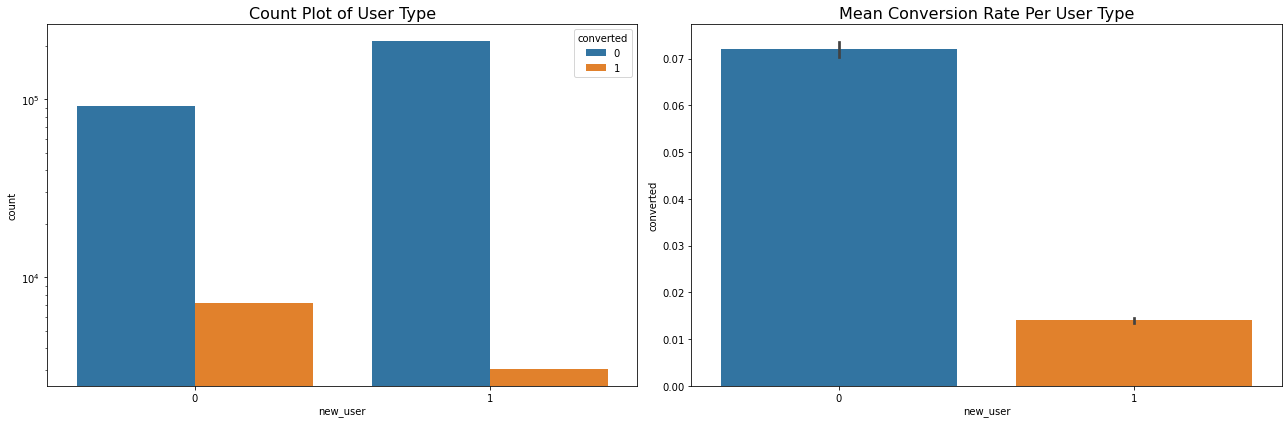

In [57]:
## visualization of different user types

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

sns.countplot(x='new_user', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of User Type', fontsize=16)
ax[0].set_yscale('log')

sns.barplot(x='new_user', y='converted', data=df, ax=ax[1])
ax[1].set_title('Mean Conversion Rate Per User Type', fontsize=16)

plt.tight_layout()
plt.show()

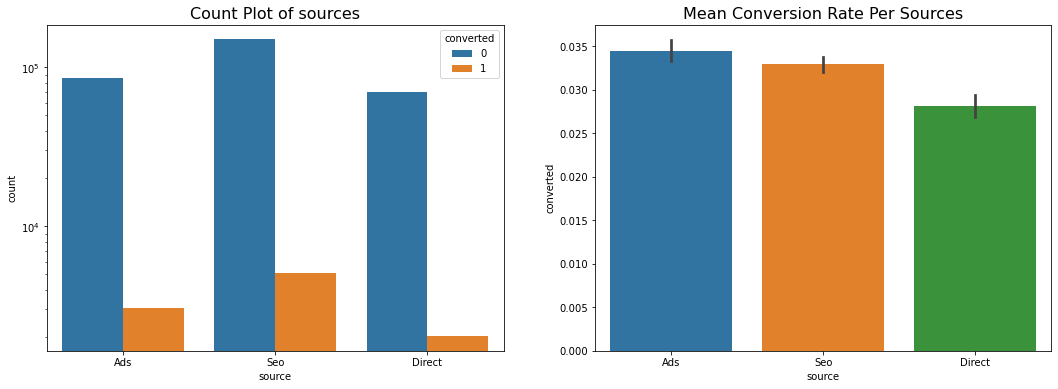

In [58]:
## visualization of different sources

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.countplot(x='source', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of sources', fontsize=16)
ax[0].set_yscale('log')

sns.barplot(x='source', y='converted', data=df, ax=ax[1])
ax[1].set_title('Mean Conversion Rate Per Sources', fontsize=16)

plt.show()

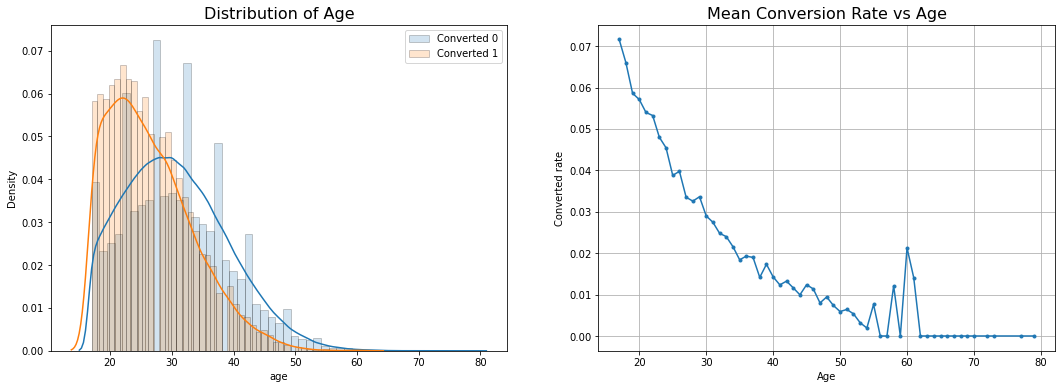

In [59]:
# Visualization of age

group_line = df.loc[:,['age','converted']].groupby('age').mean().reset_index()
hist_kws = {'histtype': 'bar','edgecolor':'black', 'alpha':0.2}

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.distplot(df[df['converted']==0]['age'], label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted']==1]['age'], label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Distribution of Age', fontsize=16)
ax[0].legend()

ax[1].plot(group_line['age'],group_line['converted'],'.-')
ax[1].set_title('Mean Conversion Rate vs Age', fontsize=16)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Mean Converted Rate')
ax[1].grid(True)

plt.show()

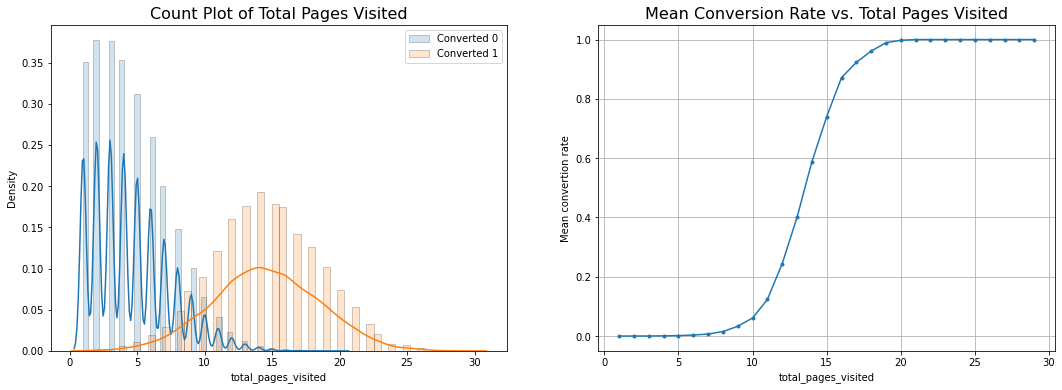

In [73]:
# Visualization of total pages visited

grouped = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df[df['converted'] == 0]['total_pages_visited'], label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['total_pages_visited'], label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Total Pages Visited', fontsize=16)
ax[0].legend()

ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total Pages Visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean Converted Rate')
ax[1].grid(True)

plt.show()

## 4. Logistic Regression Model

In [60]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [61]:
X = df.loc[:,('country', 'age', 'new_user', 'source', 'total_pages_visited')]
y = df.loc[:,'converted']

# get dummies 
X = pd.get_dummies(X)

In [62]:
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [63]:
x_train,x_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=22)

In [64]:
logist = LogisticRegression()
logist.fit(x_train, y_train)
pred_y = logist.predict(x_test)

In [71]:
logist_cm

array([[60943,   232],
       [  673,  1392]], dtype=int64)

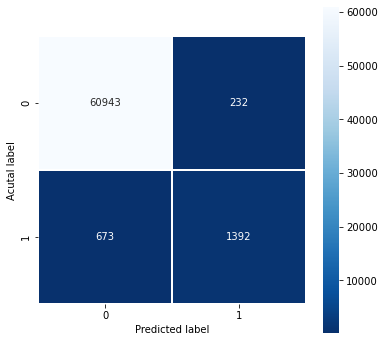

In [70]:
logist_cm = confusion_matrix(y_test, pred_y)

plt.figure(figsize=(6,6))
sns.heatmap(logist_cm, annot=True, fmt='.0f', linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Acutal label')
plt.xlabel('Predicted label')

plt.show()

In [72]:
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61175
           1       0.86      0.67      0.75      2065

    accuracy                           0.99     63240
   macro avg       0.92      0.84      0.87     63240
weighted avg       0.98      0.99      0.98     63240



From this classification report,
* In label 1, our precision is 0.86 which is not bad, but our recall is not very good, we only have 0.67
* Support between two labels are very different, which means we don't have a balance output

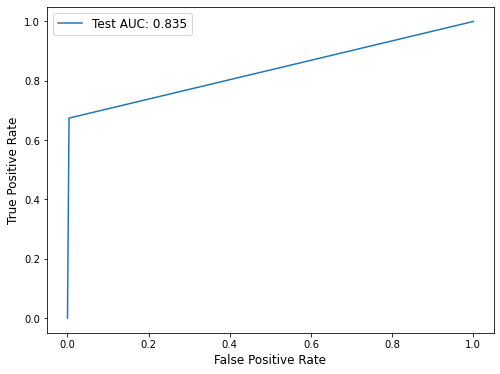

In [82]:
# ROC curves
test_fpr, test_tpr, _ = roc_curve(y_test,pred_y)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

# ROC plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

##### * As we can see above, AUC is 0.835, we will use SMOTE to deal with imbalanced problem to increase AUC

In [74]:
feat_importances = pd.DataFrame({"name":x_train.columns,"coef":logist.coef_[0]})
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
3,country_China,-3.797667,3.797667
8,source_Direct,-1.694043,1.694043
1,new_user,-1.684804,1.684804
9,source_Seo,-1.496183,1.496183
7,source_Ads,-1.476631,1.476631
2,total_pages_visited,0.758570,0.758570
6,country_US,-0.575405,0.575405
5,country_UK,-0.209136,0.209136
4,country_Germany,-0.084649,0.084649
0,age,-0.074031,0.074031


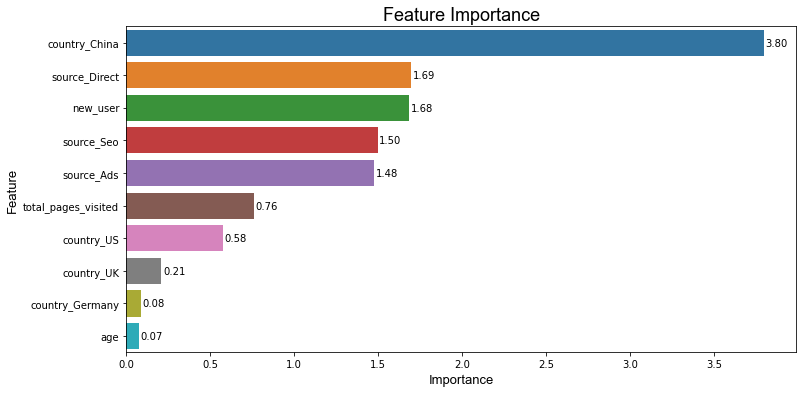

In [79]:
# Feature importance plot
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.barplot(x='importances', y='name', data=feat_importances)

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 0.01,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.title('Feature Importance', fontdict={'fontname': 'Arial', 'fontsize': 18})
plt.xlabel('Importance', fontdict={'fontname': 'Arial', 'fontsize': 13})
plt.ylabel('Feature', fontdict={'fontname': 'Arial', 'fontsize': 13})
plt.show()

#### Conclusion:

1. We can see that **the conversion rate from China was very poor**. We know that there were a lot of users coming from China, but their conversion rate was very low. So, the main task is to improve the conversion rate. I think we should consider if the design style of the websites had matched Chinese users' preferences and if the ads had met the primary needs of Chinese users.

2. We can see that **the conversion rate from Germany was good** since there are not many German users, it's a huge opportunity for us to improve this market. I think the main task is to increase the number of users from Germany, so, we should increase the number of advertisements to increase brand awareness, let more German users know the company.

3. We can see that **the conversion rate from old users was good**, I think we should keep in touch with them, try to send some coupons or discount codes to them to increase the brand loyalty.

4. We can see that **the older the user, the lower the conversion rate**. I think we should find ways to increase the number of young users, for example, referral friends to get discounts. On the other hand, we should also try to figure out why older users are reluctant to convert.

5. We can see that **total_pages_visited was positively correlated with the conversion rate**. The longer users spent on our pages, the more likely they were going to convert and buy something. I think we should send an email to remind users that there are still some products in their shopping cart or there are discounts on products they've looked at before.

## * Deal with imbalanced dataset by **SMOTE**

In [84]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X, y)

y_sm.value_counts()

1    306000
0    306000
Name: converted, dtype: int64

In [85]:
x_train,x_test, y_train, y_test = train_test_split(X_sm, y_sm,test_size=0.2,random_state=22)

In [86]:
logist = LogisticRegression()
logist.fit(x_train, y_train)
pred_y = logist.predict(x_test)
score_sm= round(accuracy_score(y_test,pred_y)* 100, 4)
score_sm

95.1634

In [87]:
print(logist_cm)

[[58134  2951]
 [ 2969 58346]]


Text(0.5, 1.0, 'Logistic regression accuracy Score:98.5689')

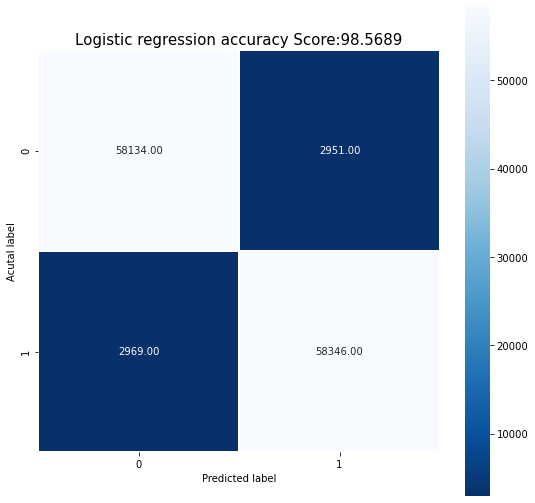

In [88]:
logist_cm = confusion_matrix(y_test, pred_y)

plt.figure(figsize=(9,9))
sns.heatmap(logist_cm, annot=True, fmt='.0f', linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Acutal label')
plt.xlabel('Predicted label')
all_sample_title = f'Logistic regression accuracy Score:{score}'
plt.title(all_sample_title, size=15)

In [89]:
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     61085
           1       0.95      0.95      0.95     61315

    accuracy                           0.95    122400
   macro avg       0.95      0.95      0.95    122400
weighted avg       0.95      0.95      0.95    122400



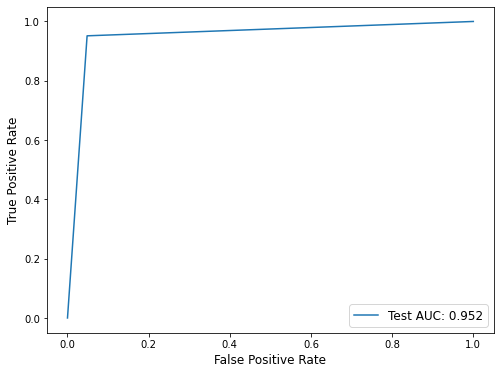

In [90]:
# ROC curves
test_fpr, test_tpr, _ = roc_curve(y_test,pred_y)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

# ROC plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

##### After solve the imbalanced problem, our AUC increase to 0.952